In [1]:
import datetime

import numpy as np
import numpy.random as rndm
import matplotlib.pyplot as plt
rng = rndm.default_rng()

In [2]:
NUM_CASTLES = 13
NUM_SOLDIERS = 100
CASTLE_POINTS = np.arange(1, NUM_CASTLES+1, dtype=np.int8)
CASTLE_SUM = CASTLE_POINTS.sum()

def random_dist():
    output = np.zeros((NUM_CASTLES,), dtype=np.int8)
    castles = rng.integers(0, NUM_CASTLES, NUM_SOLDIERS)
    for i in range(NUM_SOLDIERS):
        output[castles[i]] += 1
    return output

def battle_points(x, y):
    wins = np.zeros((NUM_CASTLES,), dtype=np.int8)
    for i in range(NUM_CASTLES):
        if x[i] < y[i]:
            wins[i] = -1
        elif x[i] > y[i]:
            wins[i] = 1
    return CASTLE_SUM + wins.dot(CASTLE_POINTS)

def battle_cmp(x, y):
    x_points = battle_points(x, y)
    if x_points > CASTLE_SUM:
        return 1
    elif x_points < CASTLE_SUM:
        return -1
    return 0

In [3]:
NUM_CONTENDERS = 3000

def battle_royale(contenders):
    wins = np.zeros((NUM_CONTENDERS,), dtype=np.int32)
    for i in range(NUM_CONTENDERS):
        for j in range(i+1, NUM_CONTENDERS):
            outcome = battle_cmp(contenders[i], contenders[j])
            if outcome > 1:
                wins[i] += 1
            elif outcome < 1:
                wins[j] += 1
    return wins

In [4]:
def snp_mutate_contender(contender):
    change_soldiers = rng.integers(0, NUM_CASTLES, 2)
    if contender[change_soldiers[0]] > 0:
        contender[change_soldiers[0]] -= 1
        contender[change_soldiers[1]] += 1

def mutate_contender(contender):
    new_contender = contender.copy()
    coin = rng.integers(0, 2)
    while coin > 0:
        snp_mutate_contender(new_contender)
        coin = rng.integers(0, 2)
    return new_contender

def evolve_contenders(contenders, wins):
    survival_threshold = np.quantile(wins, 0.5)
    triple_reproduction_threshold = np.quantile(wins, 0.95)
    reproduction_threshold = np.quantile(wins, 0.7)
    baby_contenders = []
    for i in range(NUM_CONTENDERS):
        if wins[i] >= reproduction_threshold:
            baby_contenders.append(mutate_contender(contenders[i]))
    for i in range(NUM_CONTENDERS):
        if wins[i] >= triple_reproduction_threshold:
            baby_contenders.append(contenders[i])
            baby_contenders.append(mutate_contender(contenders[i]))
    for i in range(NUM_CONTENDERS):
        if wins[i] < survival_threshold:
            if baby_contenders:
                contenders[i] = baby_contenders.pop()
            else:
                contenders[i] = random_dist()

In [5]:
contenders = np.zeros((NUM_CONTENDERS, NUM_CASTLES), dtype=np.int8)
for i in range(NUM_CONTENDERS):
    contenders[i][:] = random_dist()

In [6]:
NUM_ROUNDS = 1000
winners_circle = np.zeros((NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
dist = np.zeros((NUM_ROUNDS, NUM_CASTLES, NUM_SOLDIERS+1), dtype=np.int32)
for i in range(NUM_ROUNDS):
    for j in range(NUM_CONTENDERS):
        for k in range(NUM_CASTLES):
            dist[i,k,contenders[j,k]] += 1
    wins = battle_royale(contenders)
    win_index = wins.argmax()
    winner = contenders[win_index]
    if (i+1) % 1 == 0:
        print(datetime.datetime.now(), winner, wins[win_index])
    winners_circle[i] = winner
    evolve_contenders(contenders, wins)

2020-09-04 14:22:04.011137 [ 4  3  6 12  5  7  9  4 10  9 11 11  9] 2582
2020-09-04 14:22:43.704335 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2532
2020-09-04 14:23:23.359975 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2465
2020-09-04 14:24:03.417012 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2372
2020-09-04 14:24:43.598217 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2307
2020-09-04 14:25:23.682476 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2225
2020-09-04 14:26:04.219808 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2120
2020-09-04 14:26:43.579466 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2002
2020-09-04 14:27:22.508523 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2152
2020-09-04 14:28:01.507787 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2120
2020-09-04 14:28:41.362314 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2108
2020-09-04 14:29:20.343102 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2146
2020-09-04 14:29:59.809964 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 2267
2020-09-04 14:30:38.661378 [ 3  7  5  5  6  7  3 11

2020-09-04 15:36:25.286560 [ 0  0  7  6  0  2  3  9 18 10 18  6 21] 1885
2020-09-04 15:37:05.981914 [ 0  0  7  6  0  2  3  9 18 10 18  6 21] 1870
2020-09-04 15:37:45.597641 [ 0  0  7  6  0  2  3  9 18 10 18  6 21] 1796
2020-09-04 15:38:25.725530 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1789
2020-09-04 15:39:06.040831 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1908
2020-09-04 15:39:46.117933 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1936
2020-09-04 15:40:25.760614 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1836
2020-09-04 15:41:05.508191 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1718
2020-09-04 15:41:45.431755 [ 5  4  7  7  9  7  9  7  9 11  7 17  1] 1861
2020-09-04 15:42:25.644397 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1984
2020-09-04 15:43:05.518876 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1936
2020-09-04 15:43:44.475828 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1807
2020-09-04 15:44:23.682057 [ 3  1  8  4  5  3  4 13  1  5 11 20 22] 1734
2020-09-04 15:45:02.663094 [ 3  1  8  4  5  3  4 13

2020-09-04 16:51:32.108926 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1701
2020-09-04 16:52:12.349068 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1700
2020-09-04 16:52:52.381105 [ 3  7  8  2  6  8  7 13  6  7 10 13 10] 1586
2020-09-04 16:53:32.520788 [ 1  0  0  2  1  0 12  3 11  4 19 23 24] 1610
2020-09-04 16:54:12.322847 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1677
2020-09-04 16:54:52.040635 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1738
2020-09-04 16:55:32.774072 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1609
2020-09-04 16:56:13.241006 [ 3  7  8  2  6  8  7 13  6  7 10 13 10] 1762
2020-09-04 16:56:54.194336 [ 0  1  0  0  1  3  7  1  5 16 27 24 15] 1595
2020-09-04 16:57:34.097719 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1828
2020-09-04 16:58:13.857776 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1724
2020-09-04 16:58:53.689646 [ 0  0  8  1  5  5  0 11  2  0 18 23 27] 1592
2020-09-04 16:59:33.724005 [ 3  7  8  2  6  8  7 13  6  7 10 13 10] 1855
2020-09-04 17:00:14.200489 [ 4  4  6  4  3  9 10  7

2020-09-04 18:05:49.048838 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1729
2020-09-04 18:06:28.911156 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1789
2020-09-04 18:07:08.154382 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1658
2020-09-04 18:07:47.938527 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1621
2020-09-04 18:08:27.415834 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1665
2020-09-04 18:09:06.296191 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1708
2020-09-04 18:09:44.895979 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1737
2020-09-04 18:10:24.835397 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1586
2020-09-04 18:11:04.498005 [ 0  2  6  2  0  0  3 15 12 18 16  9 17] 1646
2020-09-04 18:11:44.067027 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1746
2020-09-04 18:12:22.722461 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1807
2020-09-04 18:13:01.697023 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1592
2020-09-04 18:13:41.476991 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1652
2020-09-04 18:14:21.426503 [ 1  1  0  4  4  6 10  5

2020-09-04 19:20:07.241638 [ 5  4  7  7  9  7  9  7  9 11  7 17  1] 1430
2020-09-04 19:20:47.370582 [ 4  4  6  8  5  8  6 11 11 15  5  5 12] 1560
2020-09-04 19:21:27.833081 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1586
2020-09-04 19:22:07.388751 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1598
2020-09-04 19:22:46.667005 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1428
2020-09-04 19:23:25.662816 [ 4  4  6  8  5  8  6 11 11 15  5  5 12] 1519
2020-09-04 19:24:05.363148 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1534
2020-09-04 19:24:45.614775 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1593
2020-09-04 19:25:23.977159 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1442
2020-09-04 19:26:03.009989 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1479
2020-09-04 19:26:42.142955 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1542
2020-09-04 19:27:20.985797 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1595
2020-09-04 19:27:59.895741 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1470
2020-09-04 19:28:38.825076 [ 7  3  7  8 12  8  4 12

2020-09-04 20:34:04.521895 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1647
2020-09-04 20:34:44.059669 [ 0  1  3  1  2  5  0  6  3 19 21 15 24] 1606
2020-09-04 20:35:23.523833 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1584
2020-09-04 20:36:02.307027 [ 0  0  0  0  1  6  1 13  9  2 18 28 22] 1543
2020-09-04 20:36:41.876416 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1672
2020-09-04 20:37:21.230801 [ 4  4  6  4  3  9 10  7 12 10  4 15 12] 1611
2020-09-04 20:38:00.449527 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1614
2020-09-04 20:38:39.892408 [ 0  0  0  0  1  6  1 13  9  2 18 28 22] 1548
2020-09-04 20:39:18.436963 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1594
2020-09-04 20:39:57.887018 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1728
2020-09-04 20:40:37.239533 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1615
2020-09-04 20:41:15.959202 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1589
2020-09-04 20:41:56.095220 [ 4  8 11  6  5  5  6  7 10  8 22  5  3] 1557
2020-09-04 20:42:36.080102 [ 1  3  5  6  8 12  9  6

2020-09-04 21:47:56.915897 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1389
2020-09-04 21:48:36.664370 [ 0  2  1  2  6  2 11  6 14 14 10 19 13] 1436
2020-09-04 21:49:16.014723 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1667
2020-09-04 21:49:54.103348 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1508
2020-09-04 21:50:33.046012 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1384
2020-09-04 21:51:12.105211 [ 4  5  1  9  7  5  4 15 13 17  9  4  7] 1397
2020-09-04 21:51:51.253003 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1543
2020-09-04 21:52:29.489855 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1640
2020-09-04 21:53:08.158321 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1419
2020-09-04 21:53:47.200074 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1471
2020-09-04 21:54:26.770627 [ 0  2  1  2  6  2 11  6 14 14 10 19 13] 1441
2020-09-04 21:55:05.086926 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1606
2020-09-04 21:55:45.277849 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1461
2020-09-04 21:56:24.308263 [ 1  3  5  6  8 12  9  6

2020-09-04 23:01:27.794183 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1522
2020-09-04 23:02:06.702543 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1548
2020-09-04 23:02:46.431120 [ 0  0  0  3  1  1  6  0  3 20 23 18 25] 1480
2020-09-04 23:03:26.207863 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1525
2020-09-04 23:04:04.955993 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1566
2020-09-04 23:04:44.058362 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1471
2020-09-04 23:05:22.982505 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1556
2020-09-04 23:06:02.503786 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1495
2020-09-04 23:06:41.712667 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1581
2020-09-04 23:07:21.122331 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1460
2020-09-04 23:08:00.429092 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1560
2020-09-04 23:08:40.064111 [ 0  0  0  3  1  1  6  0  3 20 23 18 25] 1465
2020-09-04 23:09:18.829688 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1574
2020-09-04 23:09:57.383353 [ 0  0  0  2  0  8  1  9

2020-09-05 00:15:15.063351 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1501
2020-09-05 00:15:53.702204 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1530
2020-09-05 00:16:32.520999 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1486
2020-09-05 00:17:11.460547 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1634
2020-09-05 00:17:50.711260 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1495
2020-09-05 00:18:29.519518 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1505
2020-09-05 00:19:09.175552 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1564
2020-09-05 00:19:48.587337 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1615
2020-09-05 00:20:29.034468 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1553
2020-09-05 00:21:08.512140 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1475
2020-09-05 00:21:47.249033 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1550
2020-09-05 00:22:26.614341 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1594
2020-09-05 00:23:06.189004 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1614
2020-09-05 00:23:45.601663 [ 0  1  1  4  3  4  6  4

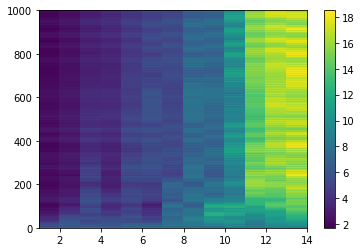

In [7]:
dist_plot = np.zeros((NUM_ROUNDS, NUM_CASTLES))
for i in range(NUM_ROUNDS):
    for j in range(NUM_CASTLES):
        for k in range(NUM_SOLDIERS):
            dist_plot[i,j] += dist[i,j,k]*k
dist_plot /= NUM_CONTENDERS
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, NUM_ROUNDS+1), dist_plot)
plt.colorbar()

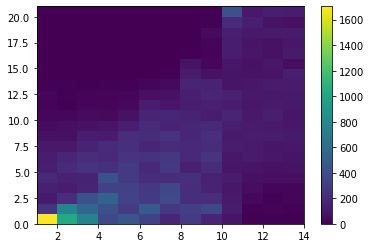

In [8]:
MAX_PLOT_SOLDIERS = 20
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, MAX_PLOT_SOLDIERS+2), dist[-1,:,:MAX_PLOT_SOLDIERS+1].T)
plt.colorbar()

In [9]:
for i in range(NUM_CONTENDERS):
    print(contenders[i])

[ 4  1  8  7  7 10  5 10 14  6  2 15 11]
[ 4  1  8  7  7 10  5 10 14  6  2 15 11]
[ 4  4  6  4  3  9 10  7 12 10  4 15 12]
[ 4  4  6  4  3  9 10  7 12 10  4 15 12]
[ 4  6  5  5  3  8 10  9 14 14  3 12  7]
[ 4  6  5  5  3  8 10  9 14 14  3 12  7]
[ 5  6  7  4  9  3  4  3  9 21  5 12 12]
[ 5  6  7  3  9  4  4  3  9 21  5 12 12]
[ 1  6  9  7  5 10  7  9  8 20  4  6  8]
[ 1  6  9  7  5 10  7  9  8 20  4  6  8]
[ 1  1  0  4  5  5 10  5 18 19  2 16 14]
[ 2  1  0  4  4  5 10  5 18 19  2 16 14]
[ 0  1  0  4  5  6 10  5 18 19  2 17 13]
[ 1  1  0  4  4  6 10  5 18 19  2 17 13]
[ 7  6  2  7  7 10  9  7  5 21  3  7  9]
[ 7  6  3  6 10  9  9  6  5 20  4  6  9]
[ 1  1  0  4  4  6 10  5 18 19  2 16 14]
[ 1  1  0  4  4  6 10  5 18 19  2 16 14]
[ 9  8  4  2 10  7  7  6  8 20  6  5  8]
[ 9  7  4  4  9  8  7  6  8 20  4  5  9]
[ 6  4  3  8  3  4 15 10  6 22  5  8  6]
[ 6  4  3  8  3  4 15 10  6 22  5  8  6]
[ 0  0  4  1  7  7  1  8  0  0 14 28 30]
[ 0  1  4  1  7  6  0 10  0  0 15 26 30]
[ 0  0  6  0  7 

[ 0  0  2  1  6  0  2  0  1 20 23 19 26]
[ 1  0  2  2  0  6  7  9  5 14 20 11 23]
[ 0  0  2  2  1  4  1  6  4 20 20 13 27]
[ 0  0  0  1  1  1 12  4 11  7 19 22 22]
[ 1  3  2  3  1  3  6  6  7 14 21  9 24]
[ 0  0  4  1  3  4  3  8  4 17 20 10 26]
[ 0  0  0  3  1  1  6  0  3 20 23 18 25]
[ 2  3  8  6  8  8  9  6 14 11  5 16  4]
[ 0  0  8  0  7  6  0 13  2  1 14 25 24]
[ 0  0  2  2  3  8  6 13  4  2 20 25 15]
[ 0  0  8  1  6  6  0 11  1  0 18 24 25]
[ 0  0  0  2  0  8  1  9  7  3 25 21 24]
[ 0  0  2  3  5  1  2  0  2 20 22 20 23]
[ 0  0  1  0  0  2 11  5  8  9 23 23 18]
[ 0  1  1  3  0  9  7 15  4  3 18 23 16]
[ 1  0  3  3  1  3  3  6  6 19 17 11 27]
[ 0  0  0  3  0  9  0  9  9  3 27 20 20]
[ 0  1  1  2  3  1  1  0  0 20 24 21 26]
[ 0  1  1  2  0 10  7 15  4  3 18 23 16]
[ 0  0  1  0  1  0  6  3  1 20 22 20 26]
[ 0  0  0  2  0  8  1  9  7  3 25 21 24]
[ 1  0  2  0  5  6  7 14  3  2 20 24 16]
[ 0  0  1  2  4  7  6 12  4  4 20 24 16]
[ 0  1  0  2  0  0  2  1  0 21 24 23 26]
[ 0  1  1  1  2 

In [11]:
NUM_CONTENDERS=1000
wins = battle_royale(winners_circle)
win_index = wins.argmax()
winner = contenders[win_index]
print(datetime.datetime.now(), winner, wins[win_index])
NUM_CONTENDERS=3000

2020-09-05 10:30:05.191403 [ 0  0  2  1  4  0  5  3  7 16 25 26 11] 871
